# DATA 602
### Project 2 - Multi-type Node Networks
### Steven Ellingson

For this project, I wanted to explore how different cast and crew would work together in movies.

So I have two connected node-types: cast/crew and movies.  While the cast and crew might seem like different things, they are connected the same way, and so they will be thought of as the same node type.

The data comes from here:  https://www.kaggle.com/rounakbanik/the-movies-dataset

In a previous project I loaded this into a database, and will be pulling it from there.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mysql.connector as dbc
import re
import warnings
import os

import networkx as nx
import networkx.algorithms.bipartite as bipartite
warnings.filterwarnings('ignore')
os.chdir('C:\\Users\\steven.ellingson\\PycharmProjects\\cuny')
db = dbc.connect(
    database='movies',
    host='127.0.0.1',
    user='root',
    passwd='soaren'
)

To narrow down the data set - I pulled only English-Speaking movies in the 2000s that have at least 10 ratings.
I appended an M to the movie ids so there is no overlap between the node types. My first time trying this I had each movie separate and my islands turned out to be mostly just movie series (i/e Harry Potter, Star Wars), which I didn't think was that interesting. Luckily I have a table of "movie collections". I grouped this so that we would only get 1 edge per person/collection.  I also removed documentaries and shorts.

In [2]:
SQL = """
select 
mc.id as edge_id,
ifnull(concat('C',cl.id),concat('M',m.id)) as movie_id,
c.id as crew_id,
c.name,
c.gender_id as gender,
mc.department,
mc.job,
ifnull(cl.name,m.title) as movie_title,
m.release_date
 from movie_crew mc
inner join movies m on mc.movie_id = m.id
inner join crew c on mc.crew_id = c.id
left join movie_collections mcl on mcl.movie_id = m.id
left join collections cl on mcl.collection_id = cl.id
where original_language = 'en'
and release_date >= '2000-01-01' and vote_count >= 10
and status = 'Released' and runtime >= 60
and mc.movie_id not in
 (
 select movie_id from movie_genres where genre_id = 99
 )
group by c.id,ifnull(concat('C',cl.id),concat('M',m.id)) 
"""

df = pd.read_sql(SQL,db)
df.head(10)

,edge_id,movie_id,crew_id,name,gender,department,job,movie_title,release_date
0,192286,C137697,13,Albert Brooks,2,CAST,CAST,Finding Nemo Collection,2003-05-30
1,192287,C137697,14,Ellen DeGeneres,1,CAST,CAST,Finding Nemo Collection,2003-05-30
2,192288,C137697,12,Alexander Gould,2,CAST,CAST,Finding Nemo Collection,2003-05-30
3,192289,C137697,5293,Willem Dafoe,2,CAST,CAST,Finding Nemo Collection,2003-05-30
4,192290,C137697,18,Brad Garrett,2,CAST,CAST,Finding Nemo Collection,2003-05-30
5,192291,C137697,19,Allison Janney,1,CAST,CAST,Finding Nemo Collection,2003-05-30
6,192292,C137697,6168,Austin Pendleton,2,CAST,CAST,Finding Nemo Collection,2003-05-30
7,192293,C137697,17401,Stephen Root,2,CAST,CAST,Finding Nemo Collection,2003-05-30
8,192294,C137697,14723,Vicki Lewis,1,CAST,CAST,Finding Nemo Collection,2003-05-30
9,192295,C137697,7911,Joe Ranft,0,CAST,CAST,Finding Nemo Collection,2003-05-30


Here is the first movie in the dataset - "Finding Nemo Collection". Because there is a sequel this shows up as a collection, and the movie_id starts with C.  Let's create a data frame for the first type of node - movie/collection.

In [3]:
movies = df[['movie_id','movie_title','release_date']]
movies.drop_duplicates(subset=['movie_id'],inplace=True)
movies.set_index('movie_id', drop=False, inplace=True)
movies.head()

,movie_id,movie_title,release_date
movie_id,,,
C137697,C137697,Finding Nemo Collection,2003-05-30
C498,C498,Heart of Gold Collection,2000-05-17
M17,M17,The Dark,2006-01-26
M20,M20,My Life Without Me,2003-03-07
C295,C295,Pirates of the Caribbean Collection,2003-07-09


Next we'll do the same for the cast/crew. 

In [4]:
crew = df[['crew_id','name','gender','department','job']]
crew.drop_duplicates(subset=['crew_id'],inplace=True)

movie_count = df[['crew_id','movie_id']].groupby(['crew_id']).count()
movie_count.columns=['count']

crew = crew.merge(movie_count, left_on = 'crew_id',right_on='crew_id')
crew.set_index('crew_id',drop=False, inplace=True)
crew.head()

,crew_id,name,gender,department,job,count
crew_id,,,,,,
13,13,Albert Brooks,2,CAST,CAST,11
14,14,Ellen DeGeneres,1,CAST,CAST,2
12,12,Alexander Gould,2,CAST,CAST,6
5293,5293,Willem Dafoe,2,CAST,CAST,43
18,18,Brad Garrett,2,CAST,CAST,15


There are A LOT of different people working on movies, so I decided to narrow things down I'll just pull some of the most common jobs. Let's look to see what those are.

In [5]:
crew[['department','job','count']].groupby(['department','job']).sum().sort_values('count', ascending=False).head(10)

count
department job                            
CAST       CAST                     144912
Production Producer                  11497
           Executive Producer         8752
Directing  Director                   6726
Production Casting                    5992
Editing    Editor                     5502
Writing    Screenplay                 5344
Camera     Director of Photography    4751
Art        Art Direction              4097
Sound      Original Music Composer    3980

OK, so we'll stick with the big wigs here - the director, producers, writers and editors.  I'll also remove any crew member who wasn't in at least 10 films to make the data easier to work with.

In [42]:
crew_small = crew[crew['count']>5]
crew_small = crew_small[crew_small['job'].isin(['CAST','Producer','Director','Executive Producer','Screenplay','Editor'])]
print('Filtered crew members down from ' + str(len(crew)) + ' to ' + str(len(crew_small)))

Filtered crew members down from 134225 to 6235


In [43]:
crew_small.sort_values('count', ascending=False).head(10)

,crew_id,name,gender,department,job,count
crew_id,,,,,,
59839,59839,Harvey Weinstein,2,Production,Executive Producer,67
1307,1307,Bob Weinstein,2,Production,Executive Producer,66
17051,17051,James Franco,2,CAST,CAST,64
11160,11160,Danny Trejo,2,CAST,CAST,57
2236,2236,Tim Bevan,2,Production,Executive Producer,56
2231,2231,Samuel L. Jackson,2,CAST,CAST,55
2238,2238,Eric Fellner,2,Production,Executive Producer,55
18999,18999,J.K. Simmons,2,CAST,CAST,54
2997,2997,Scott Rudin,2,Production,Producer,51


Not the most exciting list. Weinsteins and then James Franco.  Danny Trejo being number four is awesome, and seeing JK simmons this high on the list is great as well.
<img src="https://gossipgist.com/uploads/27082/danny-trejo-tattoodo.jpg" alt="Drawing" style="width: 200px;"/>

<img src="https://cdn3-www.comingsoon.net/assets/uploads/2020/06/HcnaPqlYvVNIoJG-800x450-noPad-768x516.jpg" alt="Drawing" style="width: 200px;"/>

In [44]:
df_small = df[df['crew_id'].isin(crew_small['crew_id'])]
df_small = df_small[df_small['job'].isin(['CAST','Producer','Director','Executive Producer','Screenplay','Editor'])]
print('Filtered edges from ' + str(len(df)) + ' to ' + str(len(df_small)))

Filtered edges from 306361 to 69267


In [46]:
G=nx.from_pandas_edgelist(df_small, 'crew_id', 'movie_id', edge_attr=True)

Let's project onto the movies first to see how that looks

In [47]:
M = bipartite.weighted_projected_graph(G, list(df_small['movie_id']))

In [48]:
m_edge_list = [[u,v,M.get_edge_data(u,v)['weight']] for u,v in M.edges]
m_edge_df = pd.DataFrame.from_records(m_edge_list, columns = ['source','target','weight'])
m_edge_df['source_title'] = m_edge_df.apply(lambda x: movies.loc[x['source'],'movie_title'] , axis=1)
m_edge_df['target_title'] = m_edge_df.apply(lambda x: movies.loc[x['target'],'movie_title'] , axis=1)
m_edge_df.sort_values('weight', ascending=False).head(20)

,source,target,weight,source_title,target_title
56535,C131295,C86311,23,Captain America Collection,The Avengers Collection
24380,C137696,M150540,15,"Monsters, Inc. Collection",Inside Out
87508,M3563,C180546,15,I Now Pronounce You Chuck & Larry,Grown Ups Collection
179724,C91657,C469648,15,Disney Buddies Collection,Santas Paw
54940,C131292,C86311,14,Iron Man Collection,The Avengers Collection
454682,M326425,M336004,13,Extraction,Heist
190781,C131296,C86311,13,Thor Collection,The Avengers Collection
310611,C86066,C427084,13,Despicable Me Collection,The Secret Life of Pets Collection
98406,M4638,M107985,13,Hot Fuzz,The World's End
215163,M11109,M245700,13,Vera Drake,Mr. Turner


Well this is interesting to me. My "collections" doesn't group all of the Marvel movies together, so they show up a lot. After that you can see some islands forming - Adam Sandler Comedies, Judd Apatow/Seth Rogen Comedies, Christopher Guest Mockumentaries, The "Cornetto Trilogy"

I'm going to create a dictionary with various "water levels" and start looking at the islands.


In [49]:
movie_title_dict = movies['movie_title'].to_dict()
island_dict = dict()
subgraph_dict = dict()
i = 0
for t in [1, 2, 3, 5, 7, 10, 15]:
    i = i + 1
    filtered_df = m_edge_df[m_edge_df['weight']>t]
    island_dict[t]=nx.Graph()
    island_dict[t].add_weighted_edges_from(filtered_df[['source','target','weight']].values.tolist())
    island_dict[t] = nx.relabel_nodes(island_dict[t],movie_title_dict)
    subgraph_dict[t] = list(island_dict[t].subgraph(c) for c in sorted(nx.connected_components(island_dict[t]), key=len, reverse=True))

Here are a couple of functions to help explore these islands.


In [50]:
def movie_connections(title1,title2):
    #Return shared crew for 2 movies
    
    crew1 = df_small[['crew_id','name','job']][df_small['movie_id'] == movies.loc[movies.movie_title==title1,'movie_id'][0]]
    crew2 = df_small[['crew_id','name','job']][df_small['movie_id'] == movies.loc[movies.movie_title==title2,'movie_id'][0]]

    return(crew1.merge(crew2, on=['crew_id','name']))

def island_connections(island, minct = 2):
    #Return a dataframe of the most common crew on an island
    
    dftemp = pd.DataFrame(columns = ['crew_id','name','job'])

    for m in island.nodes:
        dftemp = dftemp.append(df_small[['crew_id','name','job']][df_small['movie_id'] == movies.loc[movies.movie_title==m,'movie_id'][0]])

    dftemp1 = dftemp.groupby(['crew_id','name'], as_index = False).first()
    dftemp2 = dftemp.groupby(['crew_id','name'], as_index = False).count()
    dftemp2.columns = ['crew_id','name','count']
    dftemp1 = dftemp1.merge(dftemp2, on=['crew_id','name'])
    dftemp1 = dftemp1[dftemp1['count'] >= minct]
    return(dftemp1.sort_values('count', ascending = False))

def draw_islands(subgraph_list):
    plt.figure(figsize=(30,30))
    G=nx.grid_2d_graph(3,3) 
    i = 0
    for G1 in subgraph_list[:9]:
        i = i + 1
        plt.subplot(330+i)
        plt.title("Island Rank = " + str(i))
        nx.draw_networkx(G1, with_labels=True,
                          node_size = 1000,
                          font_size = 9,
                          node_color= 'lightgreen',
                          font_color = '#1a0033'
                          )

    plt.show()


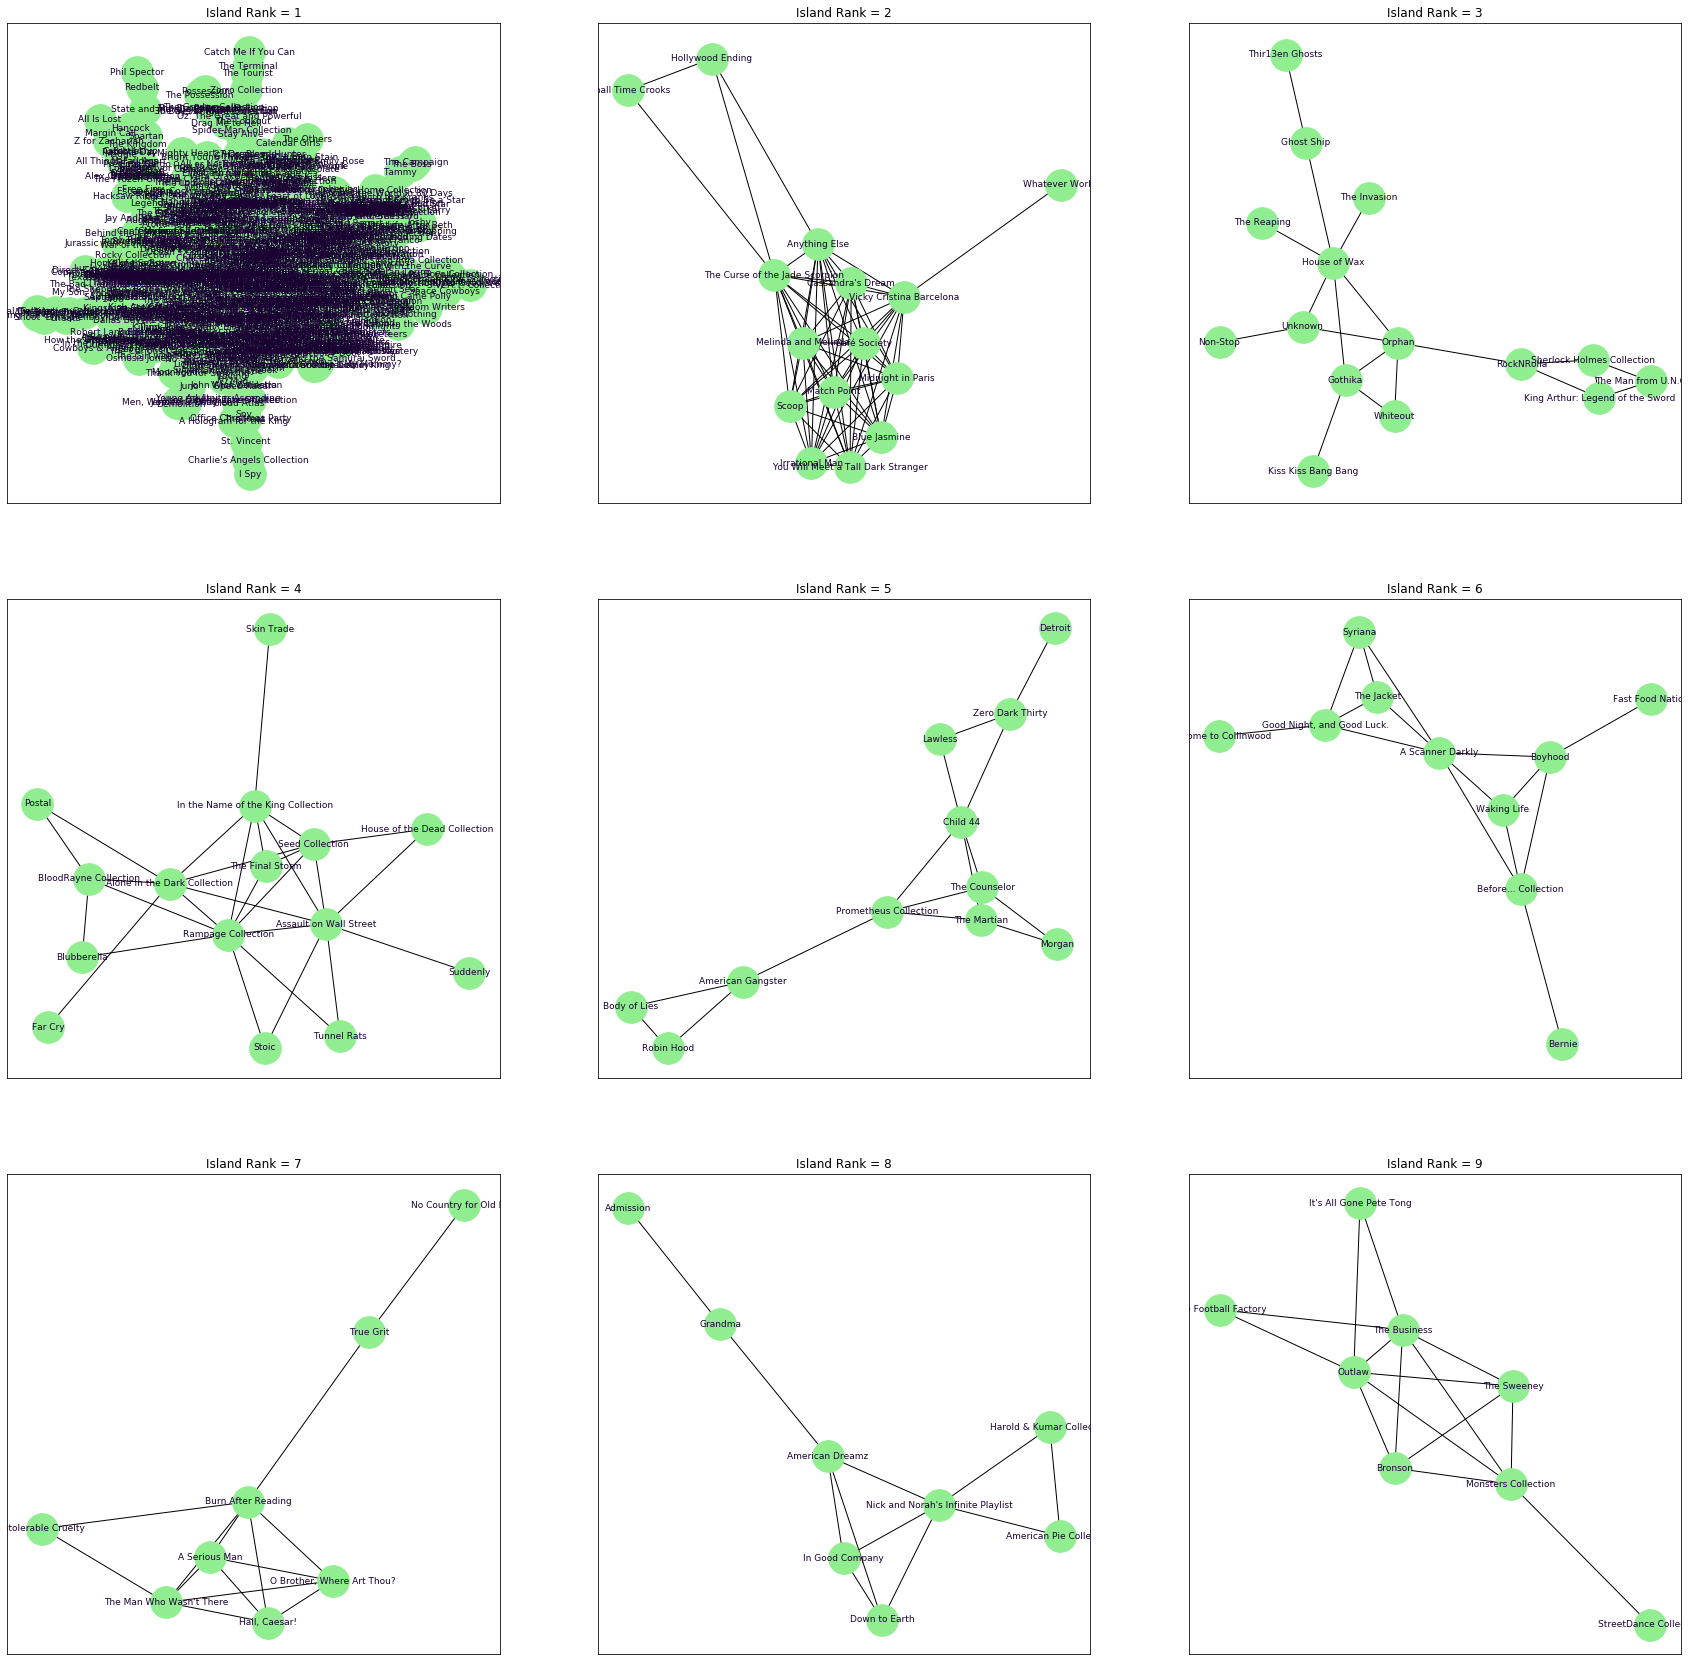

In [51]:
draw_islands(subgraph_dict[3])

Well the first graph is a nightmare, but there is some interesting stuff after that.

In [52]:
island_connections(subgraph_dict[3][1], 3)

,crew_id,name,job,count
9,1243,Woody Allen,CAST,15
18,1265,Letty Aronson,Producer,15
17,1252,Alisa Lepselter,Editor,14
20,1268,Stephen Tenenbaum,Executive Producer,13
11,1245,Scarlett Johansson,CAST,3
19,1266,Nicky Kentish Barnes,Producer,3
79,15607,Jaume Roures,Executive Producer,3


This one is Woody Allen movies.  Woody Allen is hiding out in France because of abuse allegations, so it is not a surprise to see his films on an Island by themselves. 

The third one has Guy Ritchie Movies, somehow connected to some other group of movies. I'm curious how Rock
n'Rolla is connected to Orphan.

In [54]:
movie_connections('RockNRolla', 'Orphan')

,crew_id,name,job_x,job_y
0,10841,Karel Roden,CAST,CAST
1,1091,Joel Silver,Producer,Producer
2,37162,Susan Downey,Producer,Producer
3,39726,Steve Richards,Executive Producer,Executive Producer


A few Producers and a random cast memeber I've never heard of.  This is a connection that is tenuous at best and will go away with one step up in water level.

Alright so this is Bruckheimer Island.   Because this is really just three people here, this island will disappear quickly when we raise the water level. Next we have a bunch of movies I've never heard of.

In [56]:
island_connections(subgraph_dict[3][3], 3)

,crew_id,name,job,count
47,23799,Uwe Boll,Director,14
71,43901,Shawn Williamson,Producer,10
83,60650,Michael Paré,CAST,9
68,40609,Dan Clarke,Producer,7
88,64674,Mike Dopud,CAST,6
59,32205,Brendan Fletcher,CAST,5
107,96173,Steffen Mennekes,CAST,5
5,942,Ralf Moeller,CAST,4
36,15661,Clint Howard,CAST,4
94,67977,Tyron Leitso,CAST,4


Ah, there it is.  Uwe Boll is known as possibly the worst director of all time. He clearly has some favorite cast members he likes to use.

In [57]:
island_connections(subgraph_dict[3][8], 3)

,crew_id,name,job,count
26,41532,James Richardson,Producer,8
36,60322,Allan Niblo,Producer,8
28,41538,Rupert Preston,Executive Producer,7
25,41530,Nick Love,Screenplay,6
24,41042,Danny Dyer,CAST,3
27,41535,Stuart Gazzard,Editor,3


We also have Richard Linklater island, Coen Brothers Island, and some British Stuff at the end.  Let's move the water level up to 5 and see what we have.

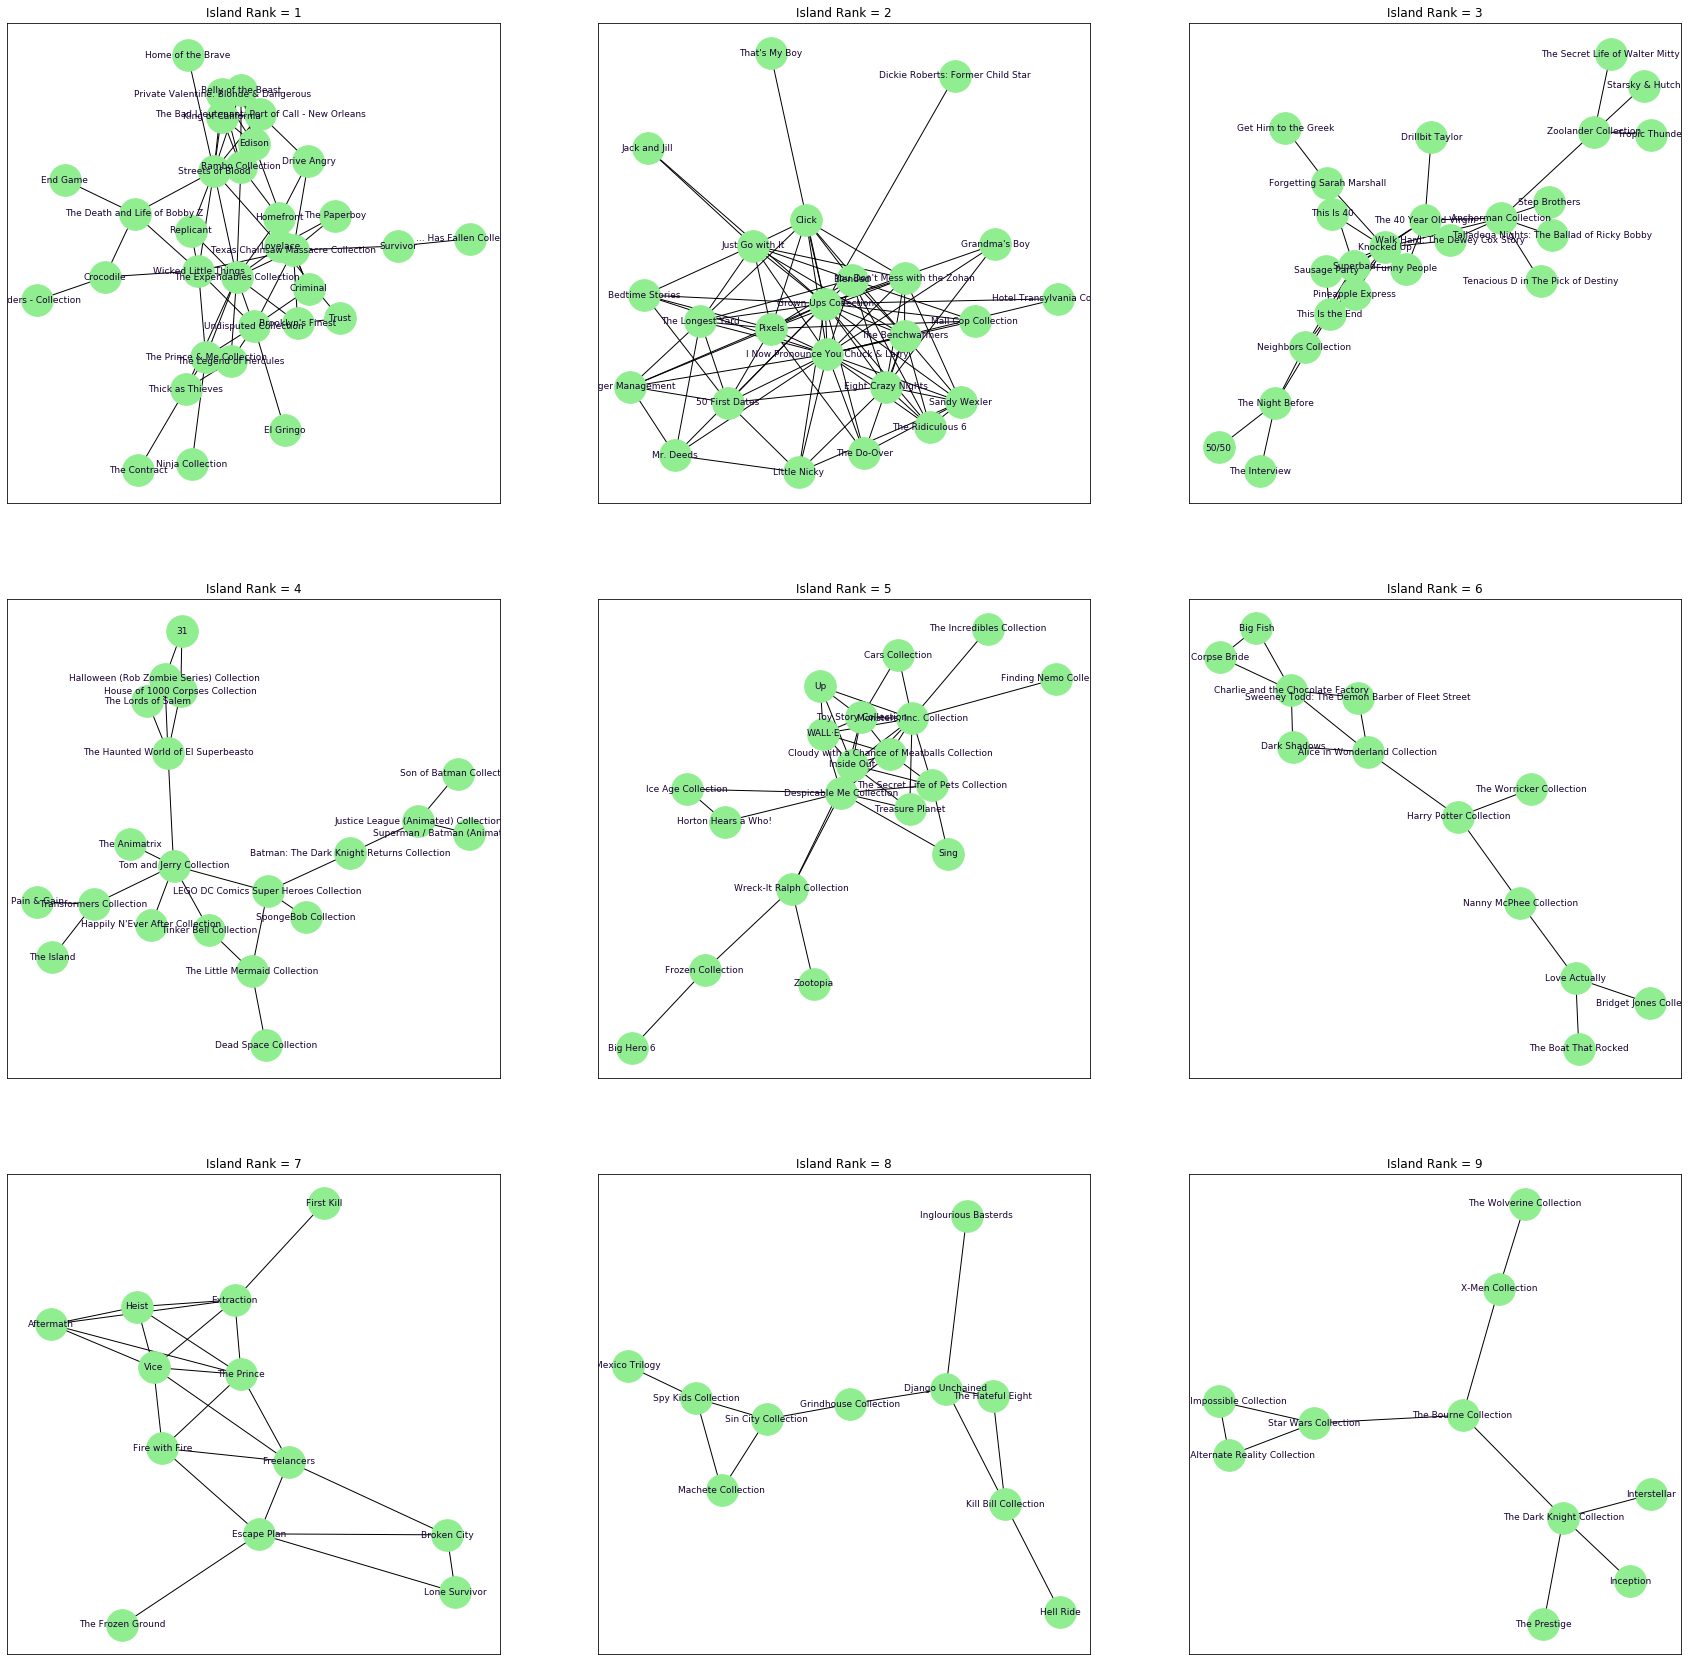

In [58]:
draw_islands(subgraph_dict[5])

Many of these are very clear - we have our Adam Sandler Island, our Judd Apatow/Seth Rogen Island, and then we have some islands that are clearly hanging on by a thread.

Graph 8 has Quentin Tarintino Movies with some weird stuff on the side.  I'm curious how Sin City connects with Spy Kids.

In [59]:
movie_connections('Sin City Collection','Spy Kids Collection')

,crew_id,name,job_x,job_y
0,56731,Jessica Alba,CAST,CAST
1,17832,Carla Gugino,CAST,CAST
2,109,Elijah Wood,CAST,CAST
3,1307,Bob Weinstein,Executive Producer,Executive Producer
4,59839,Harvey Weinstein,Executive Producer,Executive Producer
5,5911,Elizabeth Avellan,Producer,Producer
6,12799,Jeremy Piven,CAST,CAST
7,57674,Alexa PenaVega,CAST,CAST


In [25]:
movie_connections('Despicable Me Collection','Toy Story Collection')

,crew_id,name,job_x,job_y
0,109869,Kristen Schaal,CAST,CAST
1,84495,Jess Harnell,CAST,CAST
2,52699,Danny Mann,CAST,CAST
3,35159,Laraine Newman,CAST,CAST
4,2232,Michael Keaton,CAST,CAST
5,59784,Carlos Alazraqui,CAST,CAST


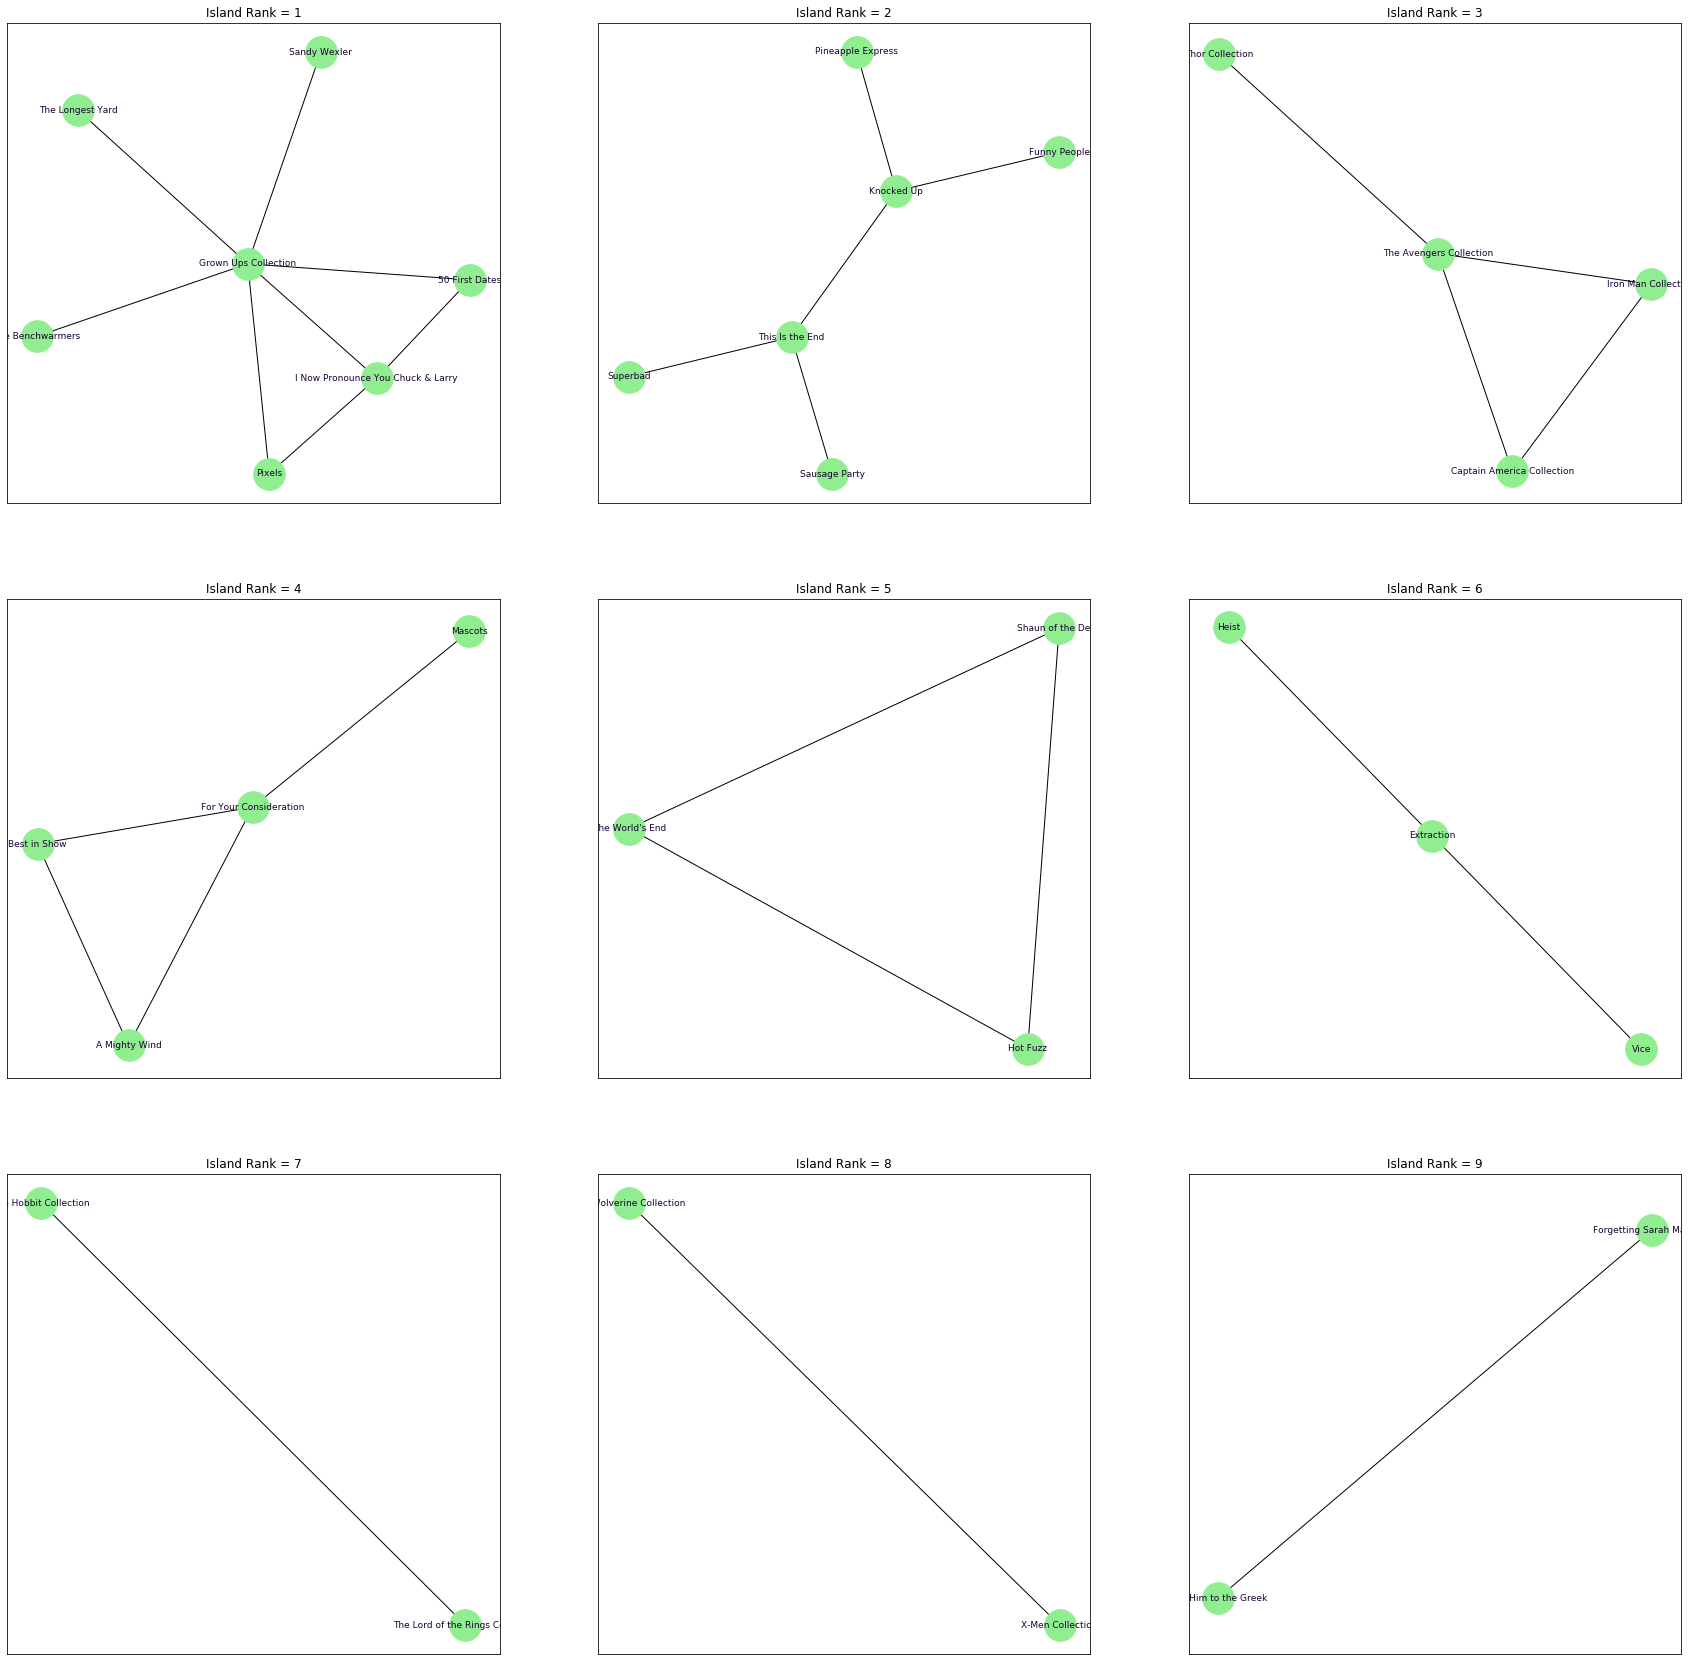

In [39]:
draw_islands(subgraph_dict[7])

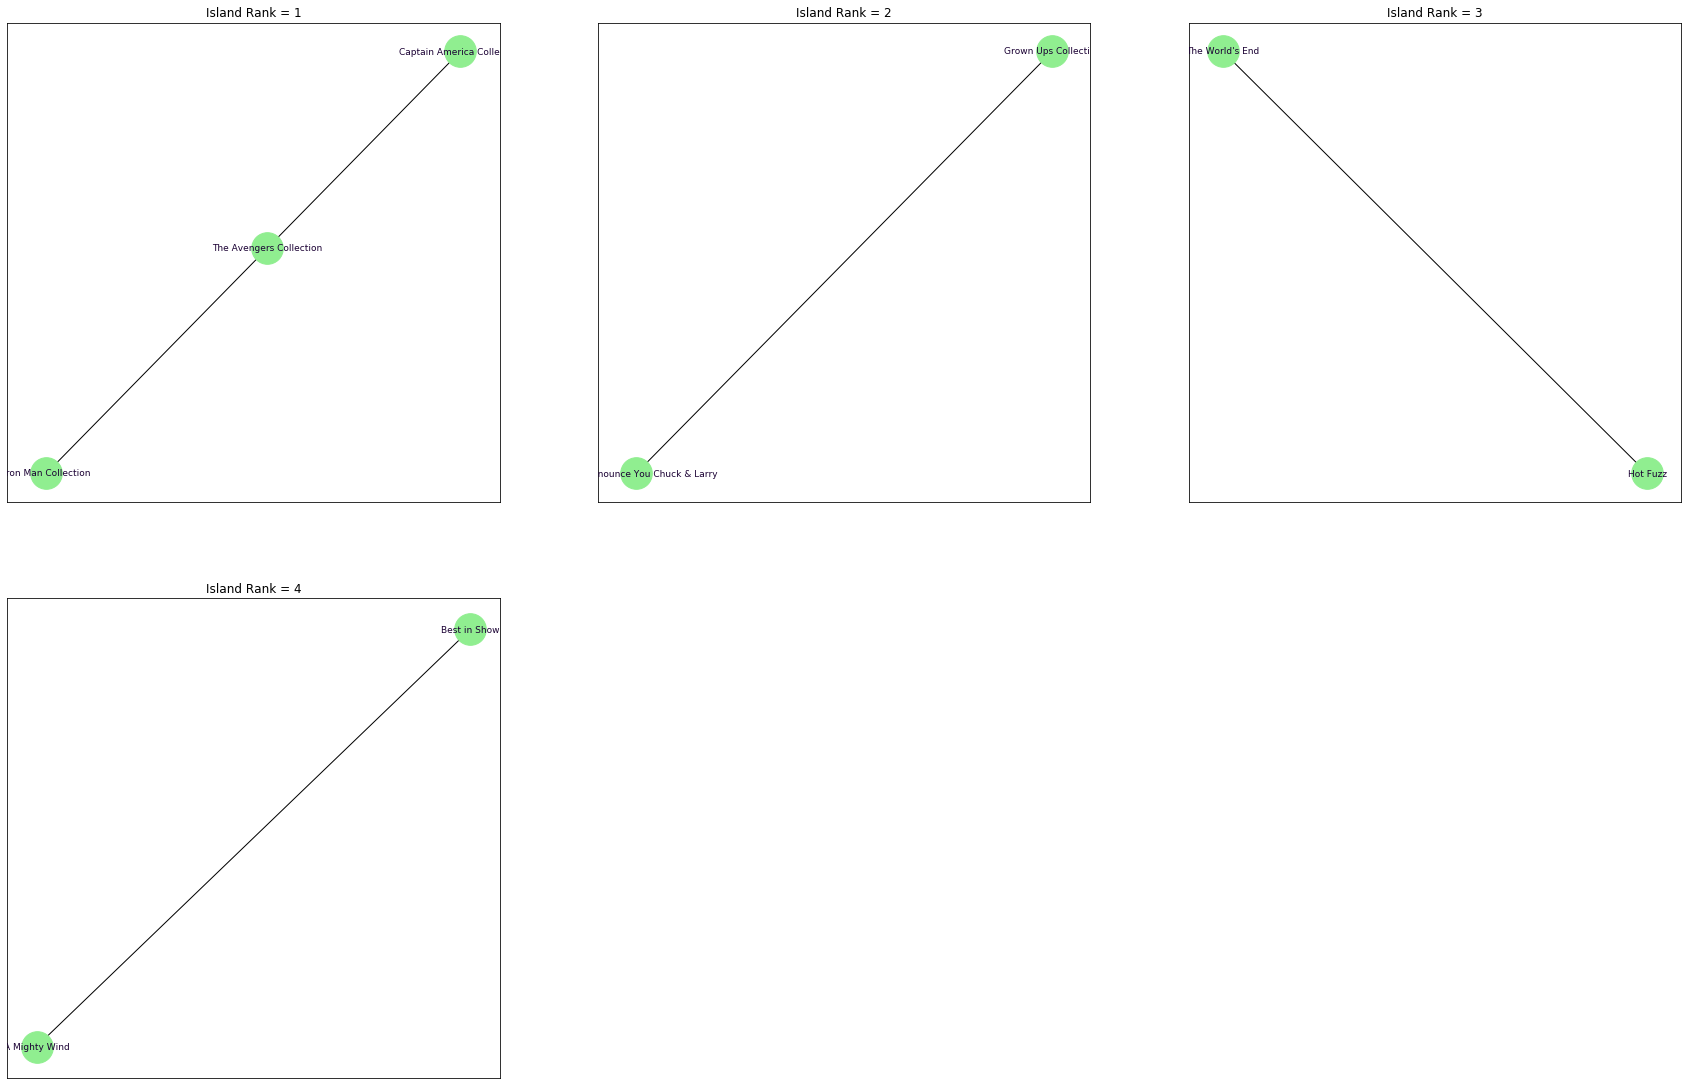

In [40]:
draw_islands(subgraph_dict[10])

In [24]:
island_connections(cc[3], 3)

,crew_id,name,job,count
69,35159,Laraine Newman,CAST,6
32,7879,John Lasseter,Producer,5
81,52699,Danny Mann,CAST,5
99,78317,Bob Bergen,CAST,5
103,84495,Jess Harnell,CAST,5
14,2232,Michael Keaton,CAST,3
18,3202,Edie McClurg,CAST,3
34,7907,John Ratzenberger,CAST,3
105,109869,Kristen Schaal,CAST,3
113,1340664,Ava Acres,CAST,3
